## BASIC PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("Iris.csv")

In [ ]:
data.head(30)
data = data.sample(frac=1).reset_index(drop=True) # Shuffle
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,14,4.3,3.0,1.1,0.1,Iris-setosa
1,7,4.6,3.4,1.4,0.3,Iris-setosa
2,75,6.4,2.9,4.3,1.3,Iris-versicolor
3,137,6.3,3.4,5.6,2.4,Iris-virginica
4,108,7.3,2.9,6.3,1.8,Iris-virginica


creating a numpy array of dependent variables from the dataframe

In [ ]:
X = data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
X = np.array(X)
print(X[:5])

[[4.3 3.  1.1 0.1]
 [4.6 3.4 1.4 0.3]
 [6.4 2.9 4.3 1.3]
 [6.3 3.4 5.6 2.4]
 [7.3 2.9 6.3 1.8]]


*we need to convert classes from categorical ('Setosa', 'Versicolor', 'Virginica') to numerical (0, 1, 2) and then to one-hot encoded ([1, 0, 0], [0, 1, 0], [0, 0, 1]). A class in one-hot encoded form is an array of 0s (a 0 for each different class) with one element equal to 1 in the index of the class (if the value of the class is 3, index 3 of the one-hot array will be equal to 1).*

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

Y = data["Species"]

# need to reshape Y in a vector form
Y = np.array(Y).reshape(150, 1)
print(Y.shape)

# encoding the categorical variables
Y = one_hot_encoder.fit_transform(Y)
print(Y[:5])

(150, 1)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


*Splitting data into train/ validation / test using sklearn. 
Initially the data will be split into train/test and then the training data will be further split into train/validation.*


In [ ]:
from sklearn.model_selection import train_test_split

# creating test and train split from original data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
# creating train and validation split from train data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

In [ ]:
X_train.shape

(114, 4)

In [ ]:
Y_train.shape

(114, 3)

TRANSPOSING X_train and Y_train for matrix mutliplication purposes

In [ ]:
X_train_new = X_train.T
Y_train_new = Y_train.T

## Implemention of NN


### sigmoid and sigmoid derivative

In [ ]:

def Sigmoid(x):
    
    return 1.0 / (1.0 + np.exp(-x))

def Sigmoid_Derivative(x):
    return np.multiply(Sigmoid(x),1-Sigmoid(x))



###  Initialize weights function

In [ ]:
def InitializeWeights(nodes,i):
  # included the bias element of each layer in the weights for that layer
    layers = len(nodes) + 1
    
    neuron_l = nodes[i]
    neuron_l_plus_one = nodes[i+1]


    # normal uniform initialization
    # w0 =  [[np.random.uniform(-1,1) for k in range(neuron_l)] for j in range(nodes[i+1])]
    
  
    # using HE initialization to initialize weights
    # To read more on initialization techniques: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78
    weight =  [[np.random.uniform(-1,1) * np.sqrt(2/nodes[i]) for k in range(neuron_l+1)] for j in range(neuron_l_plus_one)]
    weight = np.array(weight)
    return weight


#def InitializeBiases(nodes,i):
#
#    bias = np.zeros((1,nodes[i]))
#    bias = np.array(bias)
#    return bias

#PREPROCESSING
#nodes = [4,2,2,1]
#w1 = InitializeWeights(nodes,0)
#w2 = InitializeWeights(nodes,1)
#w3 = InitializeWeights(nodes,2)
#weights = [w1, w2, w3]





### cost computation

In [ ]:
def cost_compute(X_train,Y_train,weights,lambda_,activations):
      m = Y_train.size  
      temp1 = weights["w"+str(1)]
      temp2 = weights["w"+str(2)]
      temp3 = weights["w"+str(3)]
    
      a1 = activations[0]
      a2 = activations[1]
      a3 = activations[2]
      a4 = activations[3]

    

      # Add regularization term
      reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])) + np.sum(np.square(temp3[:, 1:])) ) 
    
      # log loss calc
      J = (-1 / m) * np.sum((np.log(a4) * Y_train) + np.log(1 - a4) * (1 - Y_train)) + reg_term

      return J


### forward propogation


In [ ]:
def forward_prop(X_train,Y_train,weights,m):


    # since weights has the bias term, we need to add the bias in the input layer -> X_train
    a1 = np.concatenate([np.ones((m, 1)), X_train], axis=1)
    
    # activation for hidden layer 1
    a2 = Sigmoid(a1.dot(weights["w"+str(1)].T))
    # concatenating bias in hidden layer 1
    a2 = np.concatenate([np.ones((a2.shape[0],1)),a2],axis = 1)

   
    # activation for hidden layer 2
    a3 = Sigmoid(a2.dot(weights["w"+str(2)].T))
    # concatenating bias in hidden layer 2
    a3 = np.concatenate([np.ones((a3.shape[0],1)),a3],axis = 1)

    # activation for output layer
    a4 = Sigmoid(a3.dot(weights["w"+str(3)].T))

    return [a1,a2,a3,a4]


### back propogation

In [ ]:
def back_prop(Y_train, weights,activations,m,lambda_,lr):

    Theta1_grad = np.zeros(weights["w"+str(1)].shape)
    Theta2_grad = np.zeros(weights["w"+str(2)].shape)
    Theta3_grad = np.zeros(weights["w"+str(3)].shape)
    
    a1 = activations[0]
    a2 = activations[1]
    a3 = activations[2]
    a4 = activations[3] 

    error_4 =  a4 - Y_train  # error for output layer(l = 4)
    error_3 =  np.dot(error_4,weights["w"+str(3)])[:, 1:] * Sigmoid_Derivative(np.dot(a2,weights["w"+str(2)].T))  # error for 2nd hidden layer (l = 3)
    error_2 =  np.dot(error_3,weights["w"+str(2)])[:, 1:] * Sigmoid_Derivative(np.dot(a1,weights["w"+str(1)].T))  # error for 2nd hidden layer (l = 2)

    D3 = np.dot(error_4.T , a3)
    D2 = np.dot(error_3.T , a2)
    D1 = np.dot(error_2.T , a1)
    
    
    # Add regularization to gradient

     # for the bias element we do not add the derivative of regularizer
    Theta1_grad = (1 / m) * D1
    Theta2_grad = (1 / m) * D2
    Theta3_grad = (1 / m) * D3
    
    # for all other elements other than the bias term we need to add the derivative of regularizer
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * weights["w"+str(1)][:, 1:]
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * weights["w"+str(2)][:, 1:]
    Theta3_grad[:, 1:] = Theta3_grad[:, 1:] + (lambda_ / m) * weights["w"+str(3)][:, 1:]




    # updating weights
    weights["w"+str(1)] -= lr*Theta1_grad
    weights["w"+str(2)] -= lr*Theta2_grad
    weights["w"+str(3)] -= lr*Theta3_grad



    #grad = [Theta1_grad, Theta2_grad , Theta3_grad]

    return weights

### Prediction function:

In [ ]:
def Predict(example,y,weights):
    
    ##_Forward Propagation_##
    #print("example", example)
    m = 1
    try:
        m = y.shape[0]
    except:
      continue

    activations = forward_prop(example,y, weights,m)
    
    outputFinal = activations[-1]
    #print("output final",outputFinal)

    predicted_op = [0.0,0.0,0.0]
    predicted_op[np.argmax(outputFinal)] = 1.0

    return np.array(predicted_op) # Return prediction vector



### Function to calculate accuracy of the neural net

In [ ]:
def Accuracy(X, Y, weights):
    """Run set through network, find overall accuracy"""
    correct = 0

    for i in range(len(X)):
        x, y = X[i], list(Y[i])
        
        x = np.reshape(x,(1,x.shape[0]))
        y = np.array(y)
        y = np.reshape(y,(y.shape[0],1))
 
        guess = Predict(x,y, weights)
        guess = np.reshape(guess,(guess.shape[0],1))

        #print("y",y)
        #print("guess",guess)
        
        flag = 0
        for i in range(len(y)):
            if(y[i] != guess[i]):
              flag = 1

        if flag == 0:
          correct += 1

    print("correct",correct)
    acc = str((correct / len(X)) * 100) + "%"
    return acc



### Driver Function


In [ ]:
#nodes = [4,3,3,3]
from collections import defaultdict
import matplotlib.pyplot as plt

def Driver(X_train,Y_train,nodes, X_val = None, Y_val = None, lambda_ = 0.0, lr = 0.15,epochs=10):

   

    ip_layer_n = X_train.shape[1]
    op_layer_n = Y_train.shape[1]

    total_layers = len(nodes) + 2
    nodes = [ip_layer_n] + nodes + [op_layer_n]

    weights = defaultdict(list)
    weights["w"+str(1)] = InitializeWeights(nodes,0)
    weights["w"+str(2)] = InitializeWeights(nodes,1)
    weights["w"+str(3)] = InitializeWeights(nodes,2)

    cost = []
    for epoch in range(1,epochs+1):

        # forward propogation
        m = Y_train.shape[0]
        activations = forward_prop(X_train,Y_train,weights,m)


        # computing cost
        
        J = cost_compute(X_train,Y_train,weights,lambda_,activations)
        cost.append(J)
        # Backpropogation
        m = Y_train.shape[0]
        weights = back_prop(Y_train,weights,activations,m,lambda_,lr)


        # printing accuracy every 10 iterations
        if(epoch % 500 == 0):
            print("Epoch {}".format(epoch))
            print("Training Accuracy:{}".format(Accuracy(X_train, Y_train, weights)))
            if X_val.any():
                print("Validation Accuracy:{}".format(Accuracy(X_val, Y_val, weights)))

    #Plotting cost function vs epochs
    plt.plot(list(range(epochs)), cost)
    plt.title("Cost function vs epochs")
    plt.xlabel("epochs")
    plt.ylabel("J - cost function")
    plt.show()


    return weights
  


Epoch 500
correct 79
Training Accuracy:69.2982456140351%
correct 9
Validation Accuracy:69.23076923076923%
Epoch 1000
correct 79
Training Accuracy:69.2982456140351%
correct 9
Validation Accuracy:69.23076923076923%
Epoch 1500
correct 82
Training Accuracy:71.9298245614035%
correct 10
Validation Accuracy:76.92307692307693%
Epoch 2000
correct 94
Training Accuracy:82.45614035087719%
correct 11
Validation Accuracy:84.61538461538461%
Epoch 2500
correct 104
Training Accuracy:91.22807017543859%
correct 12
Validation Accuracy:92.3076923076923%
Epoch 3000
correct 111
Training Accuracy:97.36842105263158%
correct 13
Validation Accuracy:100.0%
Epoch 3500
correct 110
Training Accuracy:96.49122807017544%
correct 13
Validation Accuracy:100.0%
Epoch 4000
correct 110
Training Accuracy:96.49122807017544%
correct 13
Validation Accuracy:100.0%
Epoch 4500
correct 110
Training Accuracy:96.49122807017544%
correct 13
Validation Accuracy:100.0%
Epoch 5000
correct 110
Training Accuracy:96.49122807017544%
correct 1

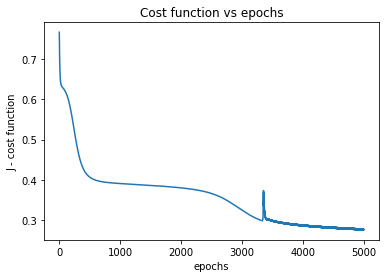

In [ ]:
 nodes = [2,4]
 weights = Driver(X_train,Y_train,nodes, X_val, Y_val,lambda_=0.6 ,lr=0.15,epochs=5000)
 

#### Testing on test data

In [ ]:
Accuracy(X_test, Y_test, weights)

correct 22


'95.65217391304348%'